In [3]:
!pip install -r ../requirements.txt

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.9/68.9 kB 3.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Using cached openml-0.14.2-py3-none-any.whl
  Using cached liac_arff-2.5.0-py3-none-any.whl
  Using cached xmltodict-0.13.0-py2.py3-none-any.whl.metadata (7.7 kB)
  Using cached minio-7.2.7-py3-none-any.whl.metadata (6.4 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.4/68.4 kB 10.9 MB/s eta 0:00:00
  Using cached pycryptodome-3.20.0-cp35-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (3.4 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 13.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.7/112.7 kB 16.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 16.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6

In [51]:
!pip install fastparquet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 24.7 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 89.7 MB/s eta 0:00:00


In [60]:
# confirm TensorFlow sees the GPU
from tensorflow.python.client import device_lib

assert "GPU" in str(device_lib.list_local_devices())

# confirm PyTorch sees the GPU
from torch import cuda

assert cuda.is_available()
assert cuda.device_count() > 0

2024-08-05 05:20:35.556041: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-08-05 05:20:35.558649: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-08-05 05:20:35.560645: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-08-05 05:20:35.562679: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-08-05 05:20:35.564648: I tensorflow/compiler/xla/stream_executo

Tesla T4


In [40]:
from importlib import reload

In [41]:
reload(openml)

<module 'openml' from '/opt/conda/envs/tensorflow/lib/python3.10/site-packages/openml/__init__.py'>

In [92]:
import time

import numpy as np
import openml
from keras.callbacks import Callback, EarlyStopping
from keras.models import Model
from keras.utils import set_random_seed
from matplotlib import pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelBinarizer, Normalizer, OneHotEncoder
from util.config import Config, config_space, get_random_hyperparams
from util.data import Dataset
from util.model import get_model

In [102]:
def get_dataset(task_id: int) -> Dataset:
    task = openml.tasks.get_task(task_id, download_splits=True)
    train_idx, test_idx = task.get_train_test_split_indices(repeat=0, fold=0)

    X, y = task.get_X_and_y(dataset_format="dataframe")
    X_train = X.iloc[train_idx]
    y_train = np.array(y.iloc[train_idx])
    X_test = X.iloc[test_idx]
    y_test = np.array(y.iloc[test_idx])

    # This changes for each dataset: see the OpenML task analysis page.
    pipeline = Pipeline([
        ("hotencoding", OneHotEncoder(handle_unknown="ignore", sparse_output=False)),
        ("scaler", Normalizer()),
        #('variance_threshold', VarianceThreshold()),
    ])
    X_train = pipeline.fit_transform(X_train)
    X_test = pipeline.transform(X_test)

    X_train = np.array(X_train)
    X_test = np.array(X_test)

    if y_train.dtype == "object":
        binarizer = LabelBinarizer()
        y_train = binarizer.fit_transform(y_train)
        y_test = binarizer.transform(y_test)

    if len(y_train.shape) == 2 and y_train.shape[1] == 1:
        y_train = y_train.flatten()
        y_test = y_test.flatten()

    y_train = y_train.astype(np.float32)
    y_test = y_test.astype(np.float32)

    return Dataset(X_train, y_train, X_test, y_test)

In [79]:
def get_convexity(model: Model, data: Dataset, config: Config):
    BATCH_SIZE = config.batch_size

    def Ka_func(xb):
        _model = Model(inputs=model.layers[0].input, outputs=model.layers[-2].output)
        return _model(xb)

    best_mu = -np.inf
    for i in range((len(data.x_train) - 1) // BATCH_SIZE + 1):
        start_i = i * BATCH_SIZE
        end_i = start_i + BATCH_SIZE
        xb = data.x_train[start_i:end_i]

        mu = np.linalg.norm(Ka_func([xb])) / np.linalg.norm(model.layers[-1].weights[0])
        if mu > best_mu and mu != np.inf:
            best_mu = mu

    return best_mu

In [63]:
class FlatnessCallback(Callback):
    def __init__(self, model: Model, dataset: Dataset, config: Config) -> None:
        super().__init__()
        self.model = model
        self.dataset = dataset
        self.config = config
        self.mus = []

    def on_epoch_end(self, epoch, logs=None) -> None:
        mu = get_convexity(self.model, self.dataset, self.config)
        self.mus.append(mu)

In [66]:
#task_ids = [10101, 53, 146818, 146821, 9952, 146822, 31, 3917]
def run_experiment(task_id: int, config: dict):
    data = get_dataset(task_id)
    time.time()

    if isinstance(config, dict):
        config = Config(**config)

    model = get_model(config, data)

    early_stop = EarlyStopping(monitor="loss", patience=5, min_delta=1e-3)
    flatness_cb = FlatnessCallback(model, data, config)
    history = model.fit(data.x_train, data.y_train, batch_size=int(config.batch_size), validation_split=0.2, epochs=200, callbacks=[early_stop, flatness_cb], verbose=0)

    time.time()

    return history.history, flatness_cb.mus

In [93]:
# Need to reseed each time, otherwise config changes
set_random_seed(13)

config = get_random_hyperparams(config_space)

Config(depth=3, width=64, batch_size=128, alpha=1e-06, learning_rate_init=1.0)


In [96]:
history, mus = run_experiment(53, config)

/var/tmp/ipykernel_18760/627110411.py:3: FutureWarning: Starting from Version 0.15.0 `download_splits` will default to ``False`` instead of ``True`` and be independent from `download_data`. To disable this message until version 0.15 explicitly set `download_splits` to a bool.
  data = get_dataset(task_id)
/opt/conda/envs/tensorflow/lib/python3.10/site-packages/openml/tasks/functions.py:442: FutureWarning: Starting from Version 0.15 `download_data`, `download_qualities`, and `download_features_meta_data` will all be ``False`` instead of ``True`` by default to enable lazy loading. To disable this message until version 0.15 explicitly set `download_data`, `download_qualities`, and `download_features_meta_data` to a bool while calling `get_dataset`.
  dataset = get_dataset(task.dataset_id, *dataset_args, **get_dataset_kwargs)
/opt/conda/envs/tensorflow/lib/python3.10/site-packages/openml/tasks/task.py:150: FutureWarning: Starting from Version 0.15 `download_data`, `download_qualities`, and

Time taken: 2.96s


In [113]:
import functools
import gc
import operator

gc.collect()

29524

/opt/conda/envs/tensorflow/lib/python3.10/site-packages/openml/tasks/functions.py:442: FutureWarning: Starting from Version 0.15 `download_data`, `download_qualities`, and `download_features_meta_data` will all be ``False`` instead of ``True`` by default to enable lazy loading. To disable this message until version 0.15 explicitly set `download_data`, `download_qualities`, and `download_features_meta_data` to a bool while calling `get_dataset`.
  dataset = get_dataset(task.dataset_id, *dataset_args, **get_dataset_kwargs)
/opt/conda/envs/tensorflow/lib/python3.10/site-packages/openml/tasks/task.py:150: FutureWarning: Starting from Version 0.15 `download_data`, `download_qualities`, and `download_features_meta_data` will all be ``False`` instead of ``True`` by default to enable lazy loading. To disable this message until version 0.15 explicitly set `download_data`, `download_qualities`, and `download_features_meta_data` to a bool while calling `get_dataset`.
  return datasets.get_dataset

Time taken: 2.88s


/opt/conda/envs/tensorflow/lib/python3.10/site-packages/openml/tasks/functions.py:442: FutureWarning: Starting from Version 0.15 `download_data`, `download_qualities`, and `download_features_meta_data` will all be ``False`` instead of ``True`` by default to enable lazy loading. To disable this message until version 0.15 explicitly set `download_data`, `download_qualities`, and `download_features_meta_data` to a bool while calling `get_dataset`.
  dataset = get_dataset(task.dataset_id, *dataset_args, **get_dataset_kwargs)
/opt/conda/envs/tensorflow/lib/python3.10/site-packages/openml/tasks/task.py:150: FutureWarning: Starting from Version 0.15 `download_data`, `download_qualities`, and `download_features_meta_data` will all be ``False`` instead of ``True`` by default to enable lazy loading. To disable this message until version 0.15 explicitly set `download_data`, `download_qualities`, and `download_features_meta_data` to a bool while calling `get_dataset`.
  return datasets.get_dataset

Time taken: 2.39s


/opt/conda/envs/tensorflow/lib/python3.10/site-packages/openml/tasks/functions.py:442: FutureWarning: Starting from Version 0.15 `download_data`, `download_qualities`, and `download_features_meta_data` will all be ``False`` instead of ``True`` by default to enable lazy loading. To disable this message until version 0.15 explicitly set `download_data`, `download_qualities`, and `download_features_meta_data` to a bool while calling `get_dataset`.
  dataset = get_dataset(task.dataset_id, *dataset_args, **get_dataset_kwargs)
/opt/conda/envs/tensorflow/lib/python3.10/site-packages/openml/tasks/task.py:150: FutureWarning: Starting from Version 0.15 `download_data`, `download_qualities`, and `download_features_meta_data` will all be ``False`` instead of ``True`` by default to enable lazy loading. To disable this message until version 0.15 explicitly set `download_data`, `download_qualities`, and `download_features_meta_data` to a bool while calling `get_dataset`.
  return datasets.get_dataset

Time taken: 3.02s


/opt/conda/envs/tensorflow/lib/python3.10/site-packages/openml/tasks/functions.py:442: FutureWarning: Starting from Version 0.15 `download_data`, `download_qualities`, and `download_features_meta_data` will all be ``False`` instead of ``True`` by default to enable lazy loading. To disable this message until version 0.15 explicitly set `download_data`, `download_qualities`, and `download_features_meta_data` to a bool while calling `get_dataset`.
  dataset = get_dataset(task.dataset_id, *dataset_args, **get_dataset_kwargs)
/opt/conda/envs/tensorflow/lib/python3.10/site-packages/openml/tasks/task.py:150: FutureWarning: Starting from Version 0.15 `download_data`, `download_qualities`, and `download_features_meta_data` will all be ``False`` instead of ``True`` by default to enable lazy loading. To disable this message until version 0.15 explicitly set `download_data`, `download_qualities`, and `download_features_meta_data` to a bool while calling `get_dataset`.
  return datasets.get_dataset

Time taken: 3.06s


/opt/conda/envs/tensorflow/lib/python3.10/site-packages/openml/tasks/functions.py:442: FutureWarning: Starting from Version 0.15 `download_data`, `download_qualities`, and `download_features_meta_data` will all be ``False`` instead of ``True`` by default to enable lazy loading. To disable this message until version 0.15 explicitly set `download_data`, `download_qualities`, and `download_features_meta_data` to a bool while calling `get_dataset`.
  dataset = get_dataset(task.dataset_id, *dataset_args, **get_dataset_kwargs)
/opt/conda/envs/tensorflow/lib/python3.10/site-packages/openml/tasks/task.py:150: FutureWarning: Starting from Version 0.15 `download_data`, `download_qualities`, and `download_features_meta_data` will all be ``False`` instead of ``True`` by default to enable lazy loading. To disable this message until version 0.15 explicitly set `download_data`, `download_qualities`, and `download_features_meta_data` to a bool while calling `get_dataset`.
  return datasets.get_dataset

Time taken: 9.86s


/opt/conda/envs/tensorflow/lib/python3.10/site-packages/openml/tasks/functions.py:442: FutureWarning: Starting from Version 0.15 `download_data`, `download_qualities`, and `download_features_meta_data` will all be ``False`` instead of ``True`` by default to enable lazy loading. To disable this message until version 0.15 explicitly set `download_data`, `download_qualities`, and `download_features_meta_data` to a bool while calling `get_dataset`.
  dataset = get_dataset(task.dataset_id, *dataset_args, **get_dataset_kwargs)
/opt/conda/envs/tensorflow/lib/python3.10/site-packages/openml/tasks/task.py:150: FutureWarning: Starting from Version 0.15 `download_data`, `download_qualities`, and `download_features_meta_data` will all be ``False`` instead of ``True`` by default to enable lazy loading. To disable this message until version 0.15 explicitly set `download_data`, `download_qualities`, and `download_features_meta_data` to a bool while calling `get_dataset`.
  return datasets.get_dataset

Time taken: 5.65s


/opt/conda/envs/tensorflow/lib/python3.10/site-packages/openml/tasks/functions.py:442: FutureWarning: Starting from Version 0.15 `download_data`, `download_qualities`, and `download_features_meta_data` will all be ``False`` instead of ``True`` by default to enable lazy loading. To disable this message until version 0.15 explicitly set `download_data`, `download_qualities`, and `download_features_meta_data` to a bool while calling `get_dataset`.
  dataset = get_dataset(task.dataset_id, *dataset_args, **get_dataset_kwargs)
/opt/conda/envs/tensorflow/lib/python3.10/site-packages/openml/tasks/task.py:150: FutureWarning: Starting from Version 0.15 `download_data`, `download_qualities`, and `download_features_meta_data` will all be ``False`` instead of ``True`` by default to enable lazy loading. To disable this message until version 0.15 explicitly set `download_data`, `download_qualities`, and `download_features_meta_data` to a bool while calling `get_dataset`.
  return datasets.get_dataset

Time taken: 2.22s


/opt/conda/envs/tensorflow/lib/python3.10/site-packages/openml/tasks/functions.py:442: FutureWarning: Starting from Version 0.15 `download_data`, `download_qualities`, and `download_features_meta_data` will all be ``False`` instead of ``True`` by default to enable lazy loading. To disable this message until version 0.15 explicitly set `download_data`, `download_qualities`, and `download_features_meta_data` to a bool while calling `get_dataset`.
  dataset = get_dataset(task.dataset_id, *dataset_args, **get_dataset_kwargs)
/opt/conda/envs/tensorflow/lib/python3.10/site-packages/openml/tasks/task.py:150: FutureWarning: Starting from Version 0.15 `download_data`, `download_qualities`, and `download_features_meta_data` will all be ``False`` instead of ``True`` by default to enable lazy loading. To disable this message until version 0.15 explicitly set `download_data`, `download_qualities`, and `download_features_meta_data` to a bool while calling `get_dataset`.
  return datasets.get_dataset

Time taken: 3.99s


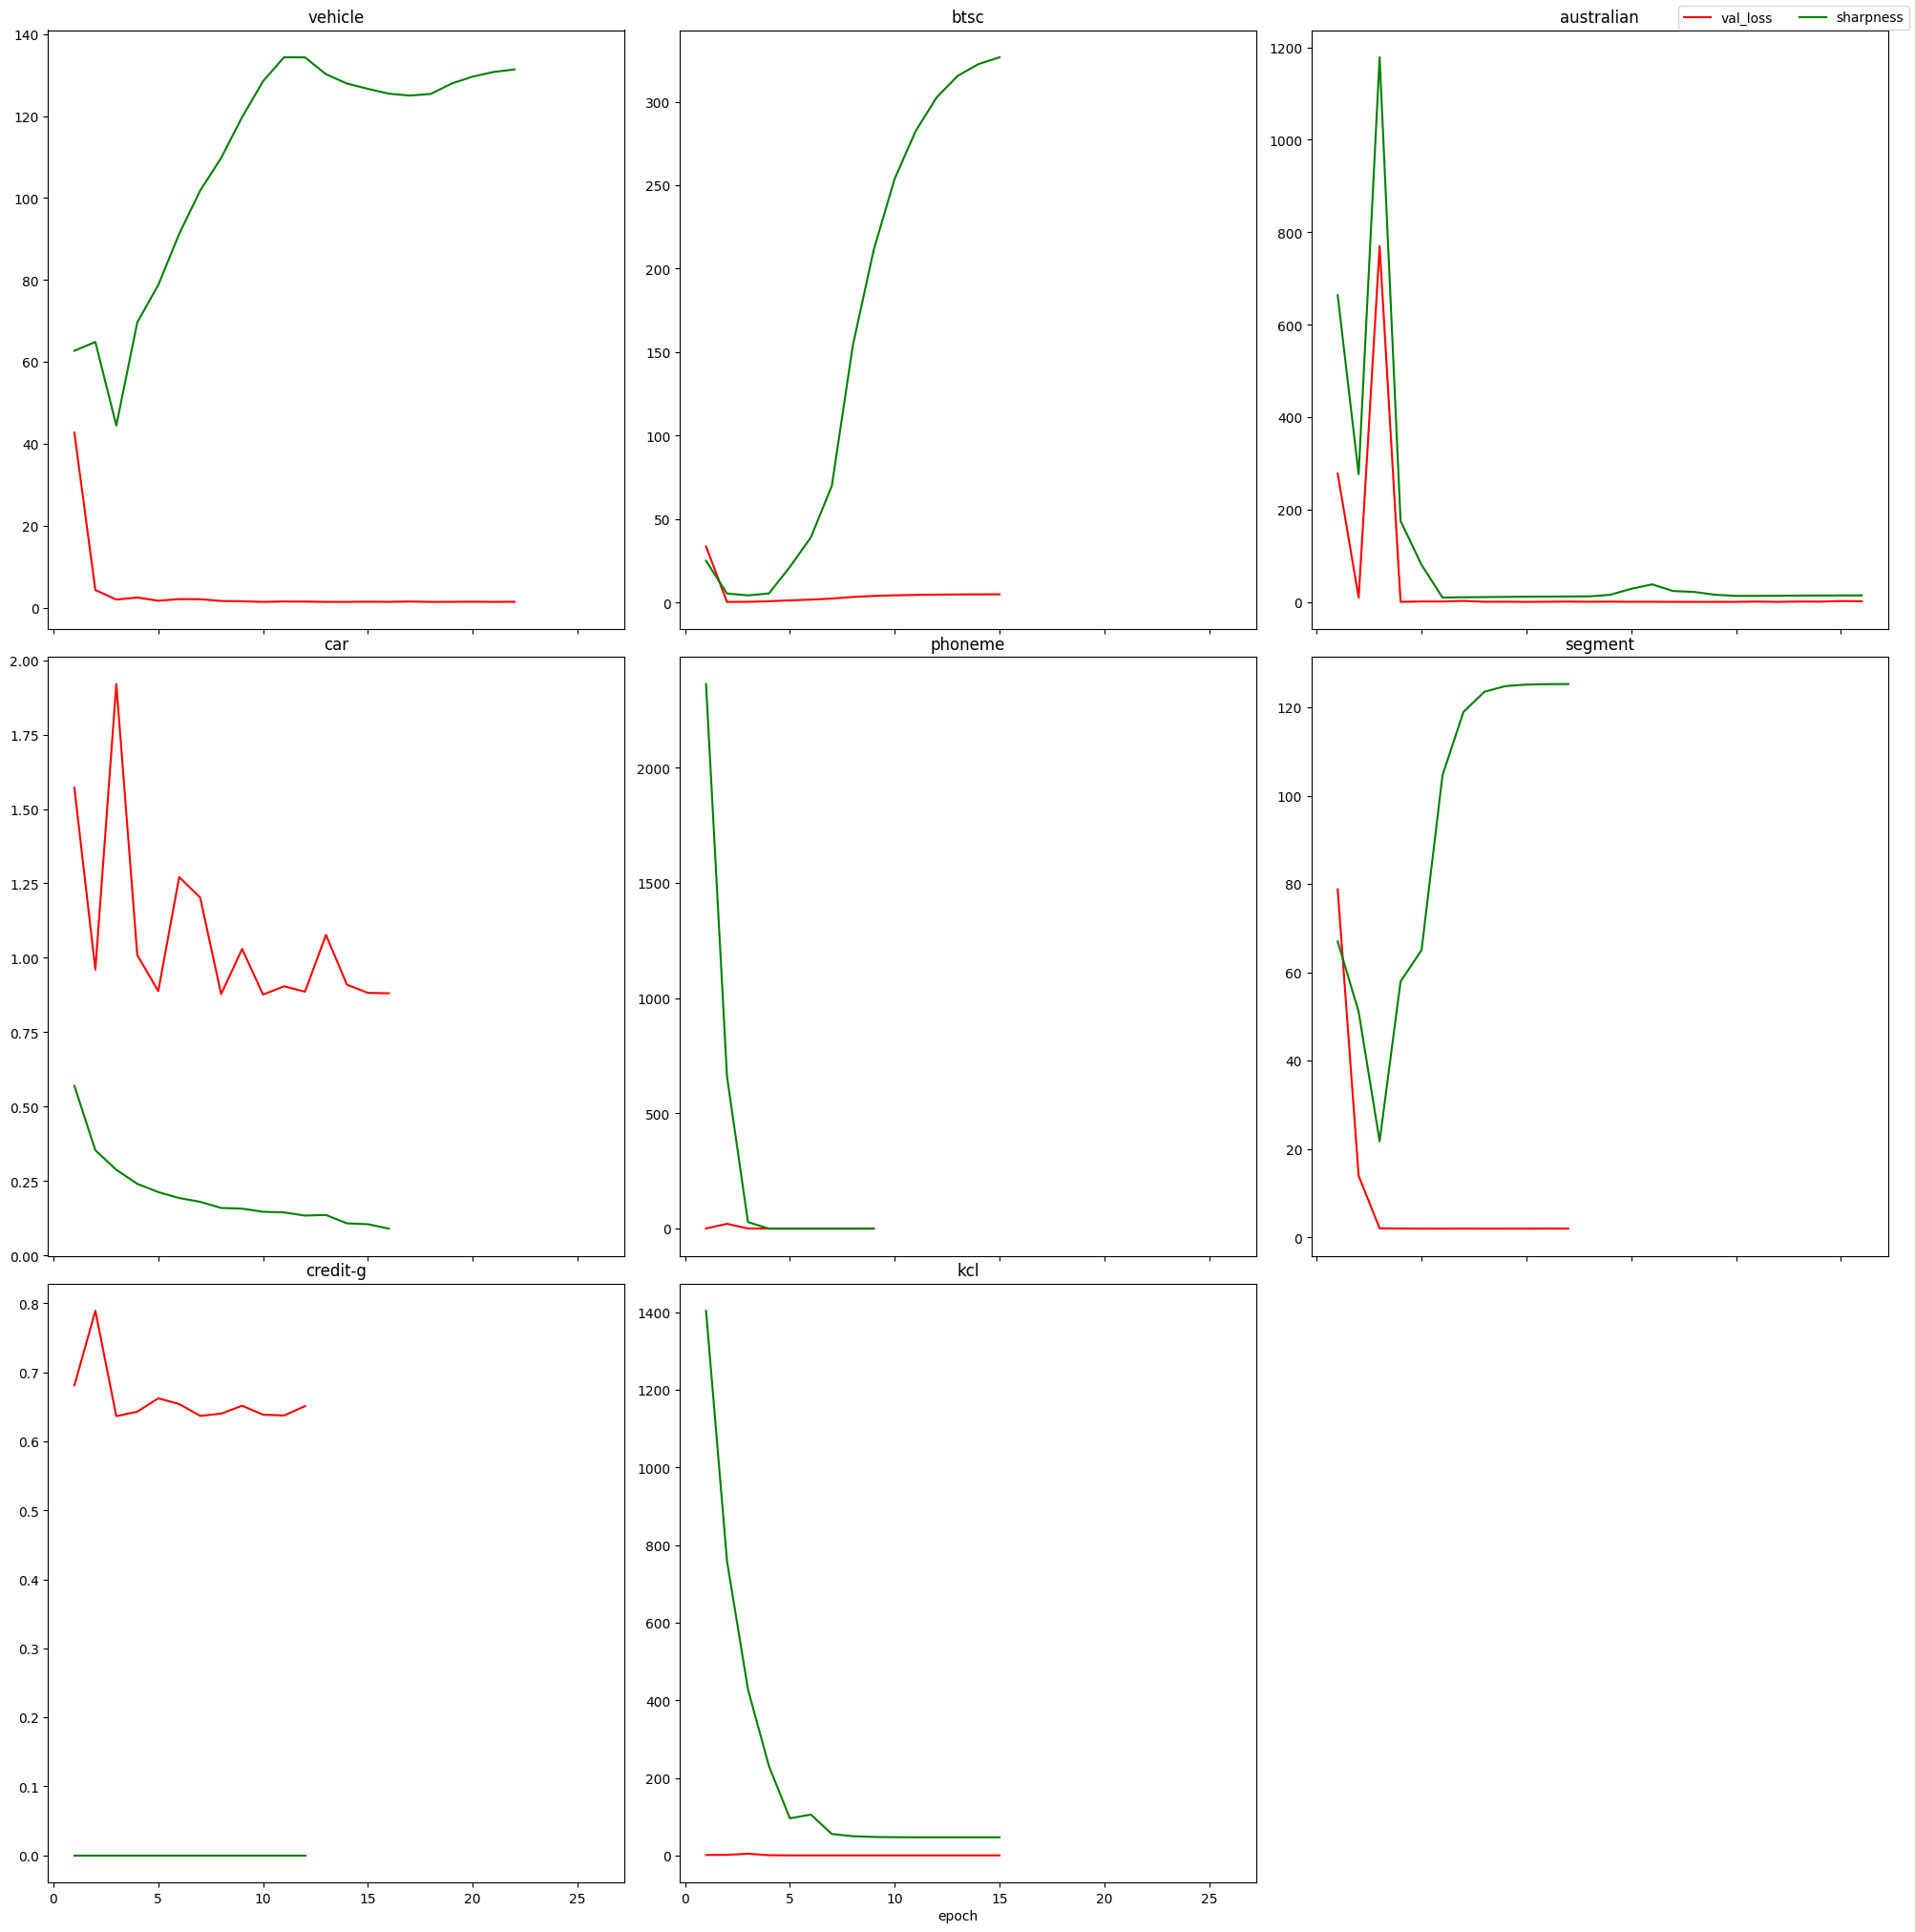

In [116]:
fig, ax = plt.subplots(3, 3, sharex=True, figsize=(20, 20), dpi=100)
fig.tight_layout()

fig.text(0.5, 0, "epoch", ha="center")

task_ids = [53, 10101, 146818, 146821, 9952, 146822, 31, 3917]
task_names = ["vehicle", "btsc", "australian", "car", "phoneme", "segment", "credit-g", "kcl"]
for i, task_id in enumerate(task_ids):
    history, mus = run_experiment(task_id, config)

    x = range(1, len(history["val_loss"]) + 1)
    ax[int(i // 3)][i % 3].set_title(task_names[i])
    ax[int(i // 3)][i % 3].plot(x, history["val_loss"], label="val_loss", color="r")
    ax[int(i // 3)][i % 3].plot(x, mus, label="sharpness", color="g")

lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
lines, labels = [functools.reduce(operator.iadd, lol, []) for lol in zip(*lines_labels, strict=False)]

fig.delaxes(ax[-1][-1])
fig.legend(lines[:2], labels[:2], loc="upper right", ncol=2)

In [117]:
fig.savefig("hpobench.svg")